In [445]:
import geopandas as gpd
import numpy as np
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

In [446]:
def get_boundaries(geo_dataframe):
    sum_coords = []
    for num, row in geo_dataframe.iterrows():
        sum_coords.extend(list(row['geometry'].exterior.coords))
    base_bound = Polygon(sum_coords).bounds
    return Polygon(
            [(base_bound[0], base_bound[1]),
             (base_bound[0], base_bound[3]),
             (base_bound[2], base_bound[3]),
             (base_bound[2], base_bound[1])
             ])

In [447]:
predicted_path = "../../test_data/fpn50_all_seasons_summer_prediction/predicted_20160830_5d7942fb-0181-49c0-8b2c-73a8becff569_rgb.geojson"
pred_poly = gpd.read_file(predicted_path)

In [448]:
prediction_boundary = get_boundaries(pred_poly)

In [449]:
pred_poly.crs

{'init': 'epsg:32636'}

In [450]:
gt_path = "../../test_data/markup/clearcuts_backup_2016-08-30/clearcuts_backup_2016-08-30.shp"
gt_poly = gpd.read_file(gt_path)

In [451]:
gt_poly = gt_poly.to_crs(pred_poly.crs)

In [452]:
gt_boundary = get_boundaries(gt_poly)

In [453]:
intersection_boundary = prediction_boundary.intersection(gt_boundary)

In [454]:
prediction_boundary.exterior.coords.xy

(array('d', [699960.0, 699960.0, 809680.0, 809680.0, 699960.0]),
 array('d', [5490250.0, 5600040.0, 5600040.0, 5490250.0, 5490250.0]))

In [455]:
gt_boundary.exterior.coords.xy

(array('d', [694094.771067144, 694094.771067144, 786340.2430196176, 786340.2430196176, 694094.771067144]),
 array('d', [5480966.664022381, 5583006.450541735, 5583006.450541735, 5480966.664022381, 5480966.664022381]))

In [456]:
intersection_boundary.exterior.coords.xy

(array('d', [699960.0, 699960.0, 786340.2430196176, 786340.2430196176, 699960.0]),
 array('d', [5490250.0, 5583006.450541735, 5583006.450541735, 5490250.0, 5490250.0]))

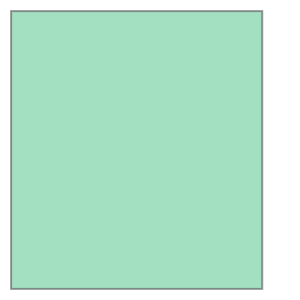

In [457]:
gt_boundary

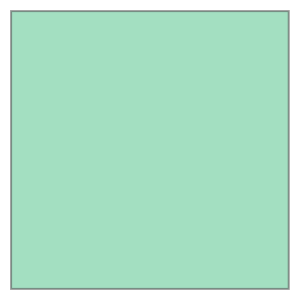

In [458]:
prediction_boundary

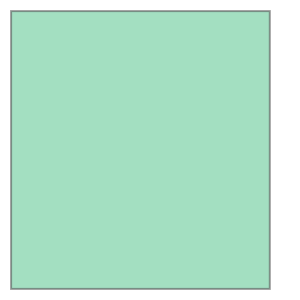

In [459]:
intersection_boundary

In [460]:
united_poly = gpd.GeoDataFrame(geometry=[intersection_boundary])

In [461]:
gt_for_f1 = gt_poly[gt_poly.intersects(intersection_boundary)]

In [462]:
pred_for_f1 = pred_poly[pred_poly.intersects(intersection_boundary)]

In [463]:
import fiona
from shapely.geometry import shape

In [464]:
shp_collection = fiona.open(gt_path)
# shp_geom = []
for i in shp_collection:
    i['geometry']
#     shp_geom.append(crds)

In [465]:
def F1_score(pred_polys, true_polys, threshold):
    """
    Calculates F1 score using shapely polygons.

    :param pred_polys: Predicted polygons.
    :param true_polys: Ground truth polygons.
    :param threshold: IoU threshold.
    :return: F1 score, recall, precision.
    """
    preds = [pred.buffer(0) for pred in pred_polys]
    truths = [true.buffer(0) for true in true_polys]

    if (len(preds) == 0) and (len(truths) == 0):
        precision = 1
        recall = 1
        F1 = 1
        return F1, recall, precision

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for truth in truths:
        ious = []
        for pred in preds:
            if not truth.intersects(pred):
                ious.append(0)
            else:
                intersection = truth.intersection(pred).area
                union = truth.union(pred).area
                ious.append(intersection / union)

        if len(ious) == 0:
            false_negatives += 1
            continue

        best = max(ious)
        if best >= threshold:
            preds.pop(ious.index(best))
            true_positives += 1
        else:
            false_negatives += 1

    false_positives = len(preds)

    try:
        precision = true_positives / (true_positives + false_positives)
    except:
        print("Precision value undefined, setting to zero")
        precision = 0

    try:
        recall = true_positives / (true_positives + false_negatives)
    except:
        print("Recall value undefined, setting to zero")
        recall = 0

    try:
        F1 = (
            2 * (precision * recall) / (precision + recall)
        )
    except:
        print("F1 value undefined, setting to zero")
        F1 = 0
    return F1, recall, precision


In [466]:
areas = [_poly.area for _poly in gt_for_f1['geometry'].values]

In [467]:
np.max(areas)

611342.2138652551

In [468]:
pred_areas = [_poly.area for _poly in pred_for_f1['geometry'].values]

In [469]:
np.max(pred_areas)

1074450.0

In [470]:
pred_filtered = pred_for_f1['geometry'].values[np.array(pred_areas) > 2950]

In [471]:
len(pred_filtered)

1369

In [472]:
len(gt_for_f1['geometry'].values)

1524

In [473]:
metrics = F1_score(pred_filtered, gt_for_f1['geometry'].values, 0.5)
F1 = metrics[0]

In [474]:
metrics

(0.3781541652264086, 0.3589238845144357, 0.3995617238860482)